# 权重衰减

应对过拟合的常见方法是权重衰减。权重衰减等价于在损失函数中添加一个正则项，以使权重值尽可能小。正则项通常为权重的平方和，有时也会使用权重的绝对值和。

方法

* 权重衰减等价于L2范数正则化

高维线性回归实验

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200 # 训练样本数，测试样本数，输入维度
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :] # 初始化模型参数
train_labels, test_labels = labels[:n_train], labels[n_train:] # 初始化模型参数

从零开始实现

In [2]:
# 初始化模型参数
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [3]:
# 定义L2范数正则化
def l2_penalty(w):
    return (w**2).sum() / 2 # 只惩罚权重w

In [4]:
# 定义训练和测试
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter= gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)

# 训练
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w) # 损失函数加上正则项
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test']) # semilogy函数用于绘制对数坐标图，各个参数：x轴，y轴，x轴标签，y轴标签，x轴数据，y轴数据，图例
    print('L2 norm of w:', w.norm().asscalar())

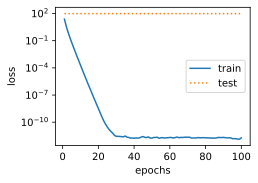

L2 norm of w: 13.155678


In [5]:
fit_and_plot(lambd=0) # lambd=0表示不使用权重衰减

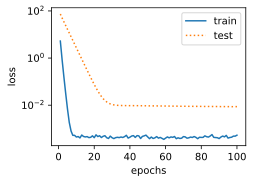

L2 norm of w: 0.04109839


In [6]:
# 使用权重衰减
fit_and_plot(lambd=3) # 使用权重衰减

简洁实现

In [7]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减,bias参数不衰减
    trainer_w= gluon.Trainer(net.collect_params('.*weight'), 'sgd', {'learning_rate': lr, 'wd': wd})
    # 各个参数：权重参数，优化器，学习率，权重衰减
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {'learning_rate': lr}) # 不对偏差参数衰减
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对权重参数衰减
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

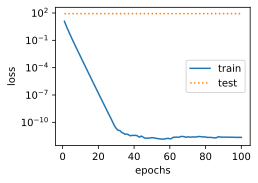

L2 norm of w: 13.530377


In [8]:
fit_and_plot_gluon(wd=0) # 不使用权重衰减

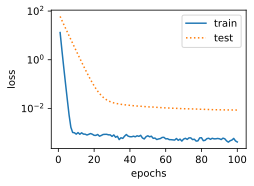

L2 norm of w: 0.04439632


In [13]:
fit_and_plot_gluon(wd=3) # 使用权重衰减

回顾训练误差和泛化误差的关系，除了权重衰减、增大训练量以及使用复杂度合适的模型，还有什么方法来应对过拟合

1. 数据增强：通过增加训练数据来提高模型的泛化能力。
2. 正则化：通过在损失函数中添加正则项来限制模型的复杂度。
3. Dropout：在训练过程中随机丢弃一部分神经元，以减少模型的依赖性。
4. Early stopping：在训练过程中监控验证集上的误差，当误差不再下降时停止训练。
5. 使用更简单的模型：选择更简单的模型可以减少模型的复杂度，从而降低过拟合的风险。

权重衰减对应贝叶斯统计中的哪个概念

1. 权重衰减（Weight Decay） 在贝叶斯统计中对应的是 最大后验估计（Maximum A Posteriori, MAP） 中的 先验分布（Prior Distribution）。
2. L2正则化（L2 Regularization），损失函数中添加了惩罚项。
3. 在贝叶斯统计中，模型的参数w被视为随机变量，其估计基于以下两个部分：一个是似然函数（Likelihood Function），即模型在给定参数w下的预测结果与实际观测值的匹配程度；另一个是先验分布（Prior Distribution），即我们对参数w的先验知识或假设。权重衰减相当于在先验分布中添加了一个L2正则项，使得参数w的估计更加稳定，从而降低过拟合的风险。